# 03 - Stats Review: The Most Dangerous Equation


- 많은 공식들이 있지만 **Standard Error 공식은 모르면 위험하다**
    - Moivre's equation: $SE = \frac{\sigma}{\sqrt{n}}$
        - SE: 평균의 표준오차
        - $\sigma$: 표준편차
        - n: 표본 크기



- 예시
    - 브라질의 3년치 학교의 평균 수능점수 데이터
    

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
# style.use("fivethirtyeight")


In [2]:
df = pd.read_csv("./data/enem_scores.csv")
display(df.sort_values(by="avg_score", ascending=False).head(10))
# display(df.info())

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


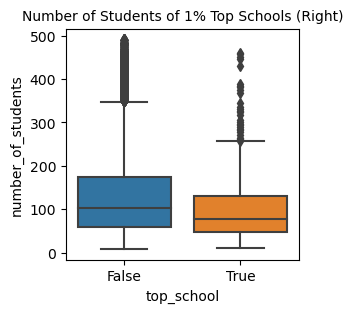

In [3]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(3,3))
sns.boxplot(x="top_school", y="number_of_students", 
            data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)",
        fontsize= 10);


- 위에서 상위 1%의 학교를 분리하면, 학생이 평균적으로 적은 것을 확인할 수 있다.
    - 작은 학교가 높은 성취를 이끌어 낸다고 볼 수있다.


- 하지만,아래와 같이 하위 1%의 살펴보면, 상위 1%와 같이 학생 수가 매우 적은 것을 확인할 수 있다.


- 아래 그래프를 통해 Moivre 공식에서 기대하는 것을 명확하게 알 수 있다.
    - 학생 수가 증가할수록 평균 점수가 더 정밀해진다. (precise)
    - 학생수가 적은 학교는 우연에 의해 평균 점수가 높거나 낮을 수 있다.
    - **Moivre 공식은 데이터는 항상 부정확하다는 사실에 기반해 말한다.**


- 통계학은 부정확함(Imprecisions)을 다루는 과학이다.
    - 확률은 지식에 대한 확신이 부족함을 인정하고, 무지를 다루는 방법을 발전하는 것이다.


- 불확실성(Uncertianty)을 정량화 방안 중 하나는 **추정치(추정값)의 분산 (Varaince of Estimates)** 이다.
    - 분산은 관측치가 중앙과 가장 있을 것 같은 값으로부터, 얼마나 떨어진지를 알려준다.
    - Moivre 공식은, 이러한 불확실성이 데이터가 많아질 수록 줄어든다는 것을 보여준다.


- 아래의 아름다운(?) 삼각형인 산점도 그래프는, 표본이 작을 때 추정치의 분산이 크다는 것을 보여준다. (위 아래 넓이가 큼)
    - 표본이 클 때는, 추정치의 분산이 작은 것을 볼 수 있으며,
    - **우리가 추정하고자 하는 ATE를 포함한 모든 요약 통계에서도 마찬가지다.**
    
    
    


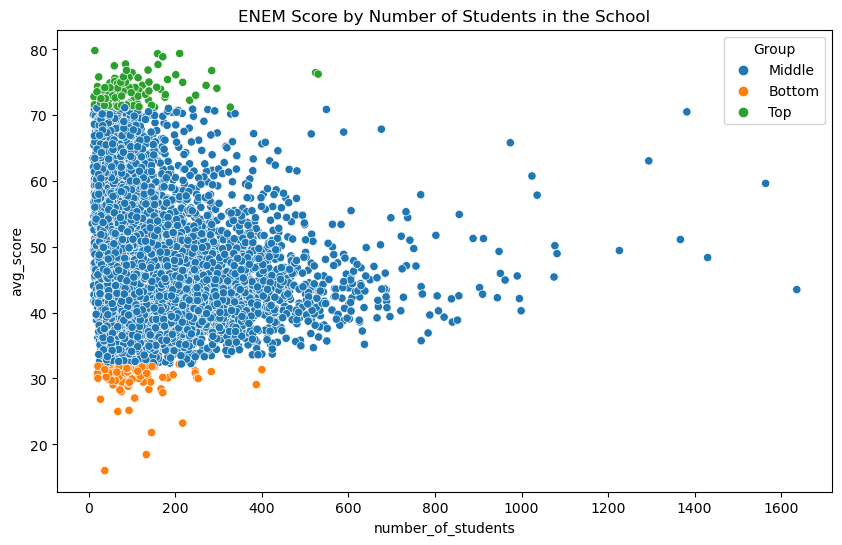

In [4]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([d["avg_score"] > q_99, d["avg_score"] < q_01],
                                                 ["Top", "Bottom"], "Middle")))
plt.figure(figsize=(10,6))
sns.scatterplot(y="avg_score", x="number_of_students", hue="Group", data=plot_data)
plt.title("ENEM Score by Number of Students in the School");

# The Standard Error of Our Estimates
---

- 1장에서 평균처리효과(Average Treatment Effect)를 $E[Y_{1}-Y_{0}]$를 처리군(실험군)과 대조군 평균 간 차이 $E[Y|T=1] - E[Y|T=0]$으로 추정했다.
    - 온라인 강의의 효과에 대한 예시로 시작했으며, 온라인 강의를 수강한 학생들의 학업 성과가 5점 정도 낮은 부정적 영향(negative impact)을 확인했다.
    - 이에 대한, 통계적 유의성(statistically significant)을 확인해보자.


- 이를 위해, 표준오차(Significant Error)를 확인해아한다. 우리의 추정의 표준편차는 아래와 같다.
    - cf. 표준오차: 표본 분포의 표준편차 또는 추정의 표준편차
    - $\hat{\sigma} = \sqrt{\frac{1}{N-1}\sum_{i=1}^N (x_{i}-\bar{x})^2}$  
        - $\bar{x}$: x의 평균
        - $ N $: 샘플의 개수
    - 이를 코드로 확인하면 아래와 같다.



In [5]:
data = pd.read_csv("./data/online_classroom.csv")
online = data.query("format_ol==1")["falsexam"]
face_to_face = data.query("format_ol==0 & format_blended==0")["falsexam"]

def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Online:", se(online))
print("SE for Face to Face:", se(face_to_face))

SE for Online: 1.5371593973041635
SE for Face to Face: 0.8723511456319106


- cf 1. 피어슨 상관 계수
    - 표준 오차: $SE(\rho_{X, Y}) = \sqrt{{{1-\rho^{2}_{X,Y}}\over{n-2}}} $
    - 95% 신뢰구간: $\rho_{X, Y}\pm t_{n-2,\alpha} SE(\rho_{X, Y})$
    - t 검정 통계량: $t_{n-2} = {{\rho_{X,Y} - 0}\over{SE(\rho_{X, Y}) }}$
    - [ref](https://namsahng.tistory.com/entry/4%EC%9E%A5-%EB%8F%85%EB%A6%BD%EC%84%B1-%EC%97%B0%EA%B4%80%EC%84%B1-%EA%B7%B8%EB%A6%AC%EA%B3%A0-%EC%83%81%EA%B4%80%EC%84%B1)
    
    
    
- cf 2. 선형회귀
    - $Y = \beta_{0} + \beta_{1} X + \epsilon$
    - 표준 오차
        - $SE(\hat{\beta_{1}})^{2} = {\sigma^{2} \over {\Sigma_{i=1}^{n}(x_{i}-\bar{x})^{2}} } $
        - $SE(\hat{\beta_{0}})^{2} = \sigma^{2} \left[ (1/n) + ({\bar{x}^{2} \over {\Sigma_{i=1}^{n}(x_{i}-\bar{x})^{2}} } )  \right]$
            - Where, $\sigma^{2} = Var(\epsilon)$
    - 95% 신뢰구간
        - $\hat{\beta_{1}} \pm 2 \cdot SE(\hat{\beta_{1}}) $
        - $\hat{\beta_{0}} \pm 2 \cdot SE(\hat{\beta_{0}}) $
    - t 검정 통계량
        - $t = {{\hat{\beta_{1}}-0}\over{SE(\hat{\beta_{1}})}}$
            - n-2의 자유도
    - ref. ISLR 66pg

# Confidence Intervals
---

- 추정치의 표준오차는 확신의 정도를 정량화한 것이다.
    - 빈도주의자 관점에서 데이터는 테이터 생성과정의 정확한 표현이다. 데이터 생성과정은 추상적이고 이상적이다. 
    - 알려지지 않은 모수(parameter)들에 대해 지배된다. 
        - 학생들의 시험에 대한 예시에서 보면, 여러 번 실험하여 여러 데이터셋을 수집할 수 있다면, 모든 것이 실제 데이터 생성과정과 유사하겠지만, 정확히 같지는 않다.


- 학생들의 시험 점수의 모분포가 $N \sim (74, 2)$ 를 따르는 것을 안다고 가정하고, 한 실험 당 500개의 표본을 뽑고 10000번 실험 해보자.
    - 실험을 히스토그램으로 그리면, 한 실험의 표본 평균에 대한 히스토그램은 아래와 같다.


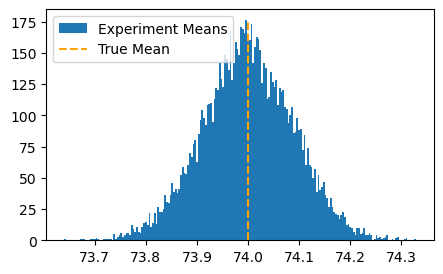

In [6]:
true_std = 2
true_mean = 74

n = 500
def run_experiment(): 
    return np.random.normal(true_mean,true_std, 500)

np.random.seed(42)

plt.figure(figsize=(5,3))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=200, label="Experiment Means")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="orange")
plt.legend();

- 위 실험은 표본 평균 & 모평균에 대한 실헝미다.
    - 표본 평균은 모평균보다 작거나 클 수 있어, 모평균과 같다고 확신할 수 없다.
    - 하지만, 표준오차를 통해 모평균이 95%안에 포함되도록 구간을 설정할 수 있다.


- 현실에서는 위와 같이 여러 번 실험할 수 없지만, 신뢰구간을 만들 수 있다. 
    - 신뢰구간은 보통 확률(일반 적으로 95%)과 함께 나타낸다.
    - 신뢰구간을 계산하기 위해서 **중심극한정리(CLT)**를 이용하며, 중심극한정리는 (모분포의 분포와 상관없이) 표본들의 평균은 정규분포를 따른다는 것을 주장한다.
    - 확률론에서 정규분포의 95%의 질량(확률)은 표준편차 $\pm 2$ 이내에 있을 때이다. (정확히는 1.96)
    - 95%가 아닌 99% 신뢰구간도 만드려면, scipy의 정규분포의 역함수(`stats.norm.ppf`)를 사용하자.


In [7]:
np.random.seed(321)
for sigma_interval in [1.96, 2]:
    exp_data = run_experiment()
    exp_se = exp_data.std() / np.sqrt(len(exp_data))
    exp_mu = exp_data.mean()
    ci_95 = (exp_mu - sigma_interval * exp_se, exp_mu + sigma_interval * exp_se)
    print(sigma_interval, ci_95)
    
z = stats.norm.ppf(.995)
print(z)
ci_99 = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci_99

1.96 (73.8306434833978, 74.16995309166167)
2 (73.94333257936464, 74.31386544861695)
2.5758293035489004


(73.88999165835375, 74.36720636962784)

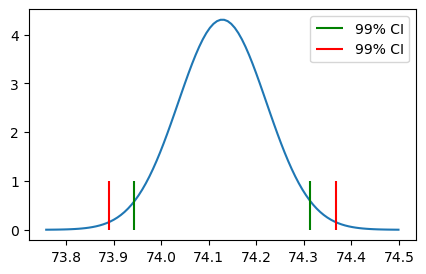

In [8]:
plt.figure(figsize=(5,3))
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci_95[1], ymin=0, ymax=1, colors='green')
plt.vlines(ci_95[0], ymin=0, ymax=1, label="99% CI", colors='green')
plt.vlines(ci_99[1], ymin=0, ymax=1, colors='red')
plt.vlines(ci_99[0], ymin=0, ymax=1, label="99% CI", colors='red')
plt.legend()
plt.show()

- 1장에서의 온라인 강의에 대한 평균 시험 점수에 대한 신뢰 구간을 확인해보자.


- 실험군과 대조군의 95% 신뢰구간이 겹치지 않는다.
    - 대면 수업 그룹의 평균점수 신뢰구간의 하한은 온라인 수업 그룹의 평균점수 신뢰구간의 상한보다 높다.
    - 이는 두 그룹의 평균의 차이가 유의미함을 나타낸다. 
        - 다시 말해 대면 수업에서 온라인 수업으로 전환할 경우 학업 성취의 유의한 인과적 감소를 주장할 수 있다.
        

In [9]:
def ci(y: pd.Series):
    return (y.mean() - 2 * se(y), y.mean() + 2 * se(y))

print("95% CI for Online:", ci(online))
print("95% for Face to Face:", ci(face_to_face))

95% CI for Online: (70.56094429049804, 76.7095818797147)
95% for Face to Face: (76.80278229206951, 80.29218687459715)


- 요약하자면, 신뢰구간은 추정치들에 대한 불확실성을 포함한 것이다. 
    - 표본이 작을 수록, 표준오차는 커지며 신뢰구간은 넓어진다. 
    - 신뢰구간은 굉장히 쉽게 계산할 수 있기 때문에, 신뢰구간이 없다면 나쁜 의도나 지식의 부족을 우려할 수 있다. 
    

- 주의할 점
    - 신뢰구간의 해석은 까다롭다.
        - 예를 들어, 95%의 신뢰구간에 **모평균이 해당 신뢰구간에 있을 확률이 95%라고 할 수 없다.**
    - 빈도주의 통계학에서 모평균은 모집단의 상수로 취급하기 때문에 신뢰구간에 모평균이 있거나 없다.
        - 다시 말해 모평균이 존재한다면, 95%가 아니라 100%이며 존재하지 않는 다면 0%이다.
        - 95% 신뢰구간은 많은 연구에서 계산된 신뢰구간이 모평균을 포함하는 빈도를 나타낸다. 
    - 95%는 구간자체에 대한 것이 아니라, 95%면 모평균이 무조건 있다는 알고리즘에 대한 확신이다. (95% is our confidence in the algorithm used to calculate the 95% CI, not on the particular interval itself.)
    - 경제학자의(저자) 관점(통계학자가 아닌)에서는 이러한 실제 관점이 유용하지는 않다.
        - 실제로 신뢰구간에 모평균이 95% 확률로 포함된다고 말하는 사람들이 틀리긴 했지만, 추정치에 대한 불확실성의 정도를 표현한다는 점에서 나쁘지는 않다.
    - 베이지안 통계학으로 바꿔 신뢰구간이 아닌 신용구간(probable/credible intervals)을 사용한다면, 95%확률로 해당 구간에 모평균이 존재한다고 말할 수 있다.
        - 샘플의 수가 크다면, 저자의 경험에 의하면 신용구간은 기존 신용구간보다 신뢰구간과 가까워진다.
        - 따라서, 신뢰구간을 해석하는데 너무 어려워할 필요는 없지만, **(바보처럼 보이지 않으려면) 추정할 때는 빼먹지 말도록 하자.**
        
    
        

<img style="float:left; margin-right:100%;" width="200" src="./data/img/stats-review/ci_xkcd.png">

# Hypothesis Testing
---

- 불확실성을 표현하는 또 다른 방법은 가설검정이다.
    - 두 집단의 평균간의 차이에 대한 질문에 답을 할 수 있다.
    - 2개의 독립적인 정규분포간의 덧셈과 뺄셈은 정규분포를 따른다는 것을 기억하자.
        - 이 때, 분산은 항상 합이다.
        - $N(\mu_{1}, \sigma_{1}^2) - N(\mu_{2}, \sigma_{2}^2) = N(\mu_{1} - \mu_{2}, \sigma_{1}^2 + \sigma_{2}^2)$  
        - $N(\mu_{1}, \sigma_{1}^2) + N(\mu_{2}, \sigma_{2}^2) = N(\mu_{1} + \mu_{2}, \sigma_{1}^2 + \sigma_{2}^2)$  
        - $\mu_{diff} = \mu_{1} - \mu_{2}$  
        - $SE_{diff} = \sqrt{SE_{1} + SE_{2}} = \sqrt{\frac{\sigma_{1}^2}{n_{1}} + \frac{\sigma_{2}^2}{n_{2}}}$  

        
    

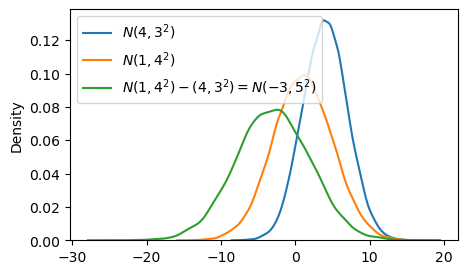

In [10]:
np.random.seed(123)
n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1
plt.figure(figsize=(5,3))
sns.distplot(n1, hist=False, label="$N(4,3^2)$")
sns.distplot(n2, hist=False, label="$N(1,4^2)$")
sns.distplot(n_diff, hist=False, label=f"$N(1,4^2) - (4,3^2) = N(-3, 5^2)$")
plt.legend()
plt.show()

- 온라인 수강에 대한 예제로 넘어가서, 두 그룹에 대한 차이에 대하여 먼저 신뢰구간을 구하면 아래와 같다.



In [11]:

diff_mu = online.mean() - face_to_face.mean()
print(diff_mu)
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(ci)

-4.912221498226955
(-8.376410208363385, -1.4480327880905248)


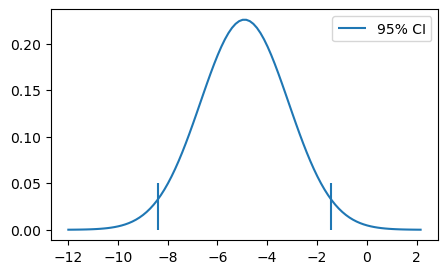

In [12]:
plt.figure(figsize=(5,3))
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=.05)
plt.vlines(ci[0], ymin=0, ymax=.05, label="95% CI")
plt.legend()
plt.show()


- 온라인 강의를 제공하는 학교와 그렇지 않은 학교의 학교점수의 차이는 -8.37에서 -1.44사이에 있음을 95% 확신 할 수 잇다.
    - 또한, 평균간의 차이에 대해 표준오차를 나누어 Z 검정통계량을 구할 수 있다.
        - $z = \frac{\mu_{diff}-H_{0}}{SE_{diff}} = \frac{(\mu_{1}-\mu_{2})}{\sqrt{{\sigma_{1}^2}/{n_{1}} + {\sigma_{2}^2}/{n_{2}}}}$  
    - $H_{0}$는 우리가 차이를 검정하고 싶은 값이다.  
    - Z 검정통계량은 관측된 차이가 얼마나 극단적인지 측정한다.
        - 평균의 차이가 0과 통계적으로 다르다는 가설을 검정하기 위해, 귀무가설을 차이가 0으로 가정한다.
        - 그리고 차이가 0이라면, 표본에서의 차이를 관찰할 수 있는 가능성을 묻는다.


- 위 검정에서의 Z 검정통계량은 표준정규분포를 따른다.
    - 따라서, Z 검정통계량이 표준편차 2 이내에 있는지 확인해보자.
    
    
- 아래 그래프를 보면, Z 검정통계량이 꽤 극단적인 값임을 알 수 있다.
    - 이러한 극단적인 값을 볼 확률이 5%보다 작음을 의미하며, 이는 대면수업에서 온라인 수업으로의 전환은 통계적으로 유의미하게 학업성취도의 하락할 수 있다는 결론을 내릴 수 있다.



-2.7792810791031224


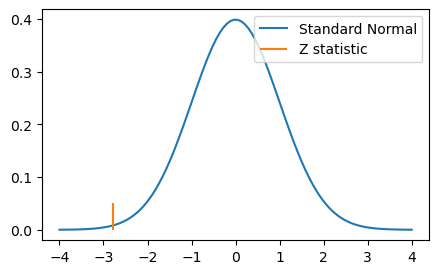

In [13]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
z = diff_mu / diff_se
print(z)
plt.figure(figsize=(5,3))
x = np.linspace(-4,4,100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, label="Standard Normal")
plt.vlines(z, ymin=0, ymax=.05, label="Z statistic", color="C1")
plt.legend()
plt.show()

- 가설검정 방법은 두 집단의 신뢰구간을 비교하는 방법보다 덜 보수적인 방안이다.
    - 두 집단의 신뢰구간이 겹치더라도, 두 집단의 차이에 대한 가설검정에서의 결과는 통계적으로 유의미할 수 있다.
    - 아래 예시를 한번 살펴보면
        - 두 집단의 신뢰구간들은 서로 겹치지만, 두 집단의 차이에 대한 신뢰구간은 0을 포함하지 않는다.
        

In [14]:
cont_mu, cont_se =  (71, 2)
test_mu, test_se = (80, 4)

diff_mu = test_mu - cont_mu
diff_se = np.sqrt(cont_se**2 + test_se**2)

print("Control 95% CI:", (cont_mu-1.96*cont_se, cont_mu+1.96*cont_se))
print("Test 95% CI:", (test_mu-1.96*test_se, test_mu+1.96*test_se))
print("Diff 95% CI:", (diff_mu-1.96*diff_se, diff_mu+1.96*diff_se))

Control 95% CI: (67.08, 74.92)
Test 95% CI: (72.16, 87.84)
Diff 95% CI: (0.23461352820082482, 17.765386471799175)


# P-values
---

- 온라인 강의를 수강한 학교와 그렇지 않은 학교의 성적 차이가 0이라면, 우리의 데이터에서의 차이인 -4.9점이 나올 확률은 5%미만이다.
    - 두 집단의 성적차이가 0일 때, 4.9점의 차이가 나올 확률은 어떻게 되는지 계산하는 방안이 p-value 이다.


- p-value란
    - 귀무가설이 참이라는 가정하에, 실험 데이터를 볼 확률
        - 귀무가설이 참인 경우 측정값을 볼 가능성이 얼마나 낮은지를 측정함.
    - p값은 $P(H_{0}|data)$가 아니라 $P(data|H_{0})$ 이다.
    - z검정에서 `stats.norm.cdf` 함수를 통해 구할 수 있다.
        

- p값은 95%나 99%같은 신뢰수준을 지정하지 않아도 된다.
    - 우리 데이터의 경우, p값은 0.2%이므로, 99.9%의 신뢰수준에서는 
        - 귀무가설을 기각할 수 없고, 신뢰구간에서 0이 포함되는 것을 확인할 수 있다.

In [15]:
print("P-value:", stats.norm.cdf(z))
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
print("95% CI:", (diff_mu - stats.norm.ppf(.975)*diff_se, diff_mu + stats.norm.ppf(.975)*diff_se))
print("99% CI:", (diff_mu - stats.norm.ppf(.995)*diff_se, diff_mu + stats.norm.ppf(.995)*diff_se))
print("99.9% CI:", (diff_mu - stats.norm.ppf(.9995)*diff_se, diff_mu + stats.norm.ppf(.9995)*diff_se))

P-value: 0.0027239680835563383
95% CI: (-8.376346553082909, -1.4480964433710017)
99% CI: (-9.46485353526404, -0.3595894611898709)
99.9% CI: (-10.728040658245558, 0.9035976617916468)


<img style="float:left; margin-right:100%;" width="350" src="./data/img/stats-review/p_value.png">

## Key Ideas
---

- 추정치에 어느 정도 확신을 위해 Moivre의 공식이 얼마나 중요하고 활용되는지 알아보았다.
- 온라인 수업 예제를 통해 온라인 수업과 대면수업의 성적차이는 통계적으로 유의미한 것을 확인했다.
- 마지막으로 A/B 테스트 비교함수를 만들어보자.
    - 또한, 귀무가설의 설정을 0이아닌 -1로도 바꿔보자.

In [16]:
def AB_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0):
    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))
    
    diff = mu1 - mu2
    se_diff = np.sqrt(test.var()/len(test) + control.var()/len(control))
    
    z_stats = (diff-h0)/se_diff
    p_value = stats.norm.cdf(z_stats)
    
    def critial(se): return -se*stats.norm.ppf((1 - confidence)/2)
    
    print(f"Test {confidence*100}% CI: {mu1} +- {critial(se1)}")
    print(f"Control {confidence*100}% CI: {mu2} +- {critial(se2)}")
    print(f"Test-Control {confidence*100}% CI: {diff} +- {critial(se_diff)}")
    print(f"Z Statistic {z_stats}")
    print(f"P-Value {p_value}")
        

In [17]:
AB_test(online, face_to_face)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.7792810791031224
P-Value 0.0027239680835563383


In [18]:
AB_test(online, face_to_face, h0=-1)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.2134920404560883
P-Value 0.013431870694630116
